## 0. Imports des modules et des images

In [2]:
import numpy as np
import sklearn as skl
import skimage as ski
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC

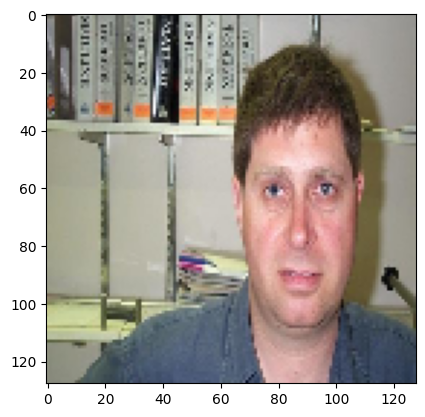

In [3]:
path_base = "./Faces/"

nb_faces = 435

images = np.empty((nb_faces,), dtype = object)

target_size = (128, 128)

for i in range(nb_faces):
    filename = f"image_{str(i+1).zfill(4)}.jpg"
    image = ski.io.imread(path_base+filename)
    images[i] = cv2.resize(image,target_size)
    

plt.imshow(images[0], cmap = 'gray')

## 1. Appliquer HOG à toutes nos images grâce au module scikit-image

In [4]:
nb_faces = 435

hog_images_vector = np.empty((nb_faces,target_size[0]*target_size[1]), dtype = object)
hog_images = np.empty((nb_faces,), dtype = object)

from skimage.feature import hog

for i in range(nb_faces):

    fd, hog_image = hog(
        images[i],
        orientations=8,
        pixels_per_cell=(4, 4), # (4,4) because either it is not enough small with (8,8)
        cells_per_block=(1, 1),
        visualize=True,
        channel_axis=-1
    )
    if i%10 == 0 : print(i)
    hog_images[i] = hog_image
    hog_images_vector[i] = hog_image.flatten()


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430


<Figure size 2000x2000 with 0 Axes>

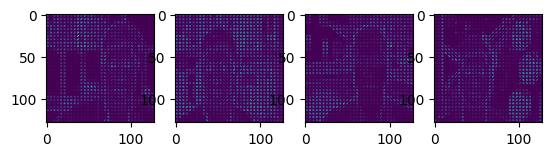

In [5]:
plt.figure(figsize = (20,20))
fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(hog_images[i])

## 2. Labellisation des images

On labellise à la main chaque image, avec chaque étiquette/classe correspondant à une personne différente.

In [6]:
nb_person = 31
nb_faces = 435

labels = np.zeros((nb_faces,1), dtype=int)

classes = np.arange(nb_person)

labels[0:22] = 0
labels[22:41] = 1
labels[41:46] = 2
labels[46:68] = 3
labels[68:89] = 4
labels[89:112] = 5
labels[112:132] = 6
labels[132:137] = 7
labels[137:158] = 8
labels[158:163] = 9
labels[163:168] = 10
labels[168:173] = 11
labels[173:193] = 12
labels[193:214] = 13
labels[214:239] = 14
labels[239:261] = 15
labels[261:266] = 16
labels[266:285] = 17
labels[285:305] = 18
labels[305:325] = 19
labels[325:345] = 20
labels[345:365] = 21
labels[365:387] = 22
labels[387] = 23
labels[388] = 24 
labels[389] = 25
labels[390] = 26
labels[391] =  27
labels[392:397] = 28
labels[397:417] = 29
labels[417:nb_faces] = 30

## 3. Entraînement du SVM

Pour utiliser un modèle SVM, on doit avoir a minima 2 données appartenenant à chaque classe (car on trace un vecteur avec a minima 2 points dans un espace). On élimine donc les images étant seule élément d'une classe. 

In [7]:
X = hog_images_vector.copy()
Y = labels.copy().reshape(-1,1)
C = classes.copy()

X = np.concatenate((X[:387], X[392:]))
Y = np.concatenate((Y[:387], Y[392:]))
C = np.concatenate((C[:23], C[28:]))

print(X.shape)

nb_faces = X.shape[0]
nb_person = C.shape[0]

X = X.reshape(nb_faces, target_size[0]*target_size[1])
Y = Y.reshape(nb_faces,)

print(X.shape)
print(Y.shape)
print("Number of faces :",nb_faces)

(430, 16384)
(430, 16384)
(430,)
Number of faces : 430


On commence par séparer les données en 3 ensembles : l'ensemble d'entraînement, l'ensemble de validation et l'ensemble de test, avec une répartition de 80%, 10% et 10% des données disponibles (données de validation et de test faible, car le jeu de données n'est pas très grand).

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, test_size=1/10, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, shuffle=True, test_size=1/9, stratify=Y_train)

print(X_train.shape, X_val.shape, X_test.shape)

(344, 16384) (43, 16384) (43, 16384)


On vérifie qu'il y ait bien un nombre équivalent de photos d'une même personne dans les 3 datasets (fait par l'option stratify).

In [9]:
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_val, return_counts=True))
print(np.unique(Y_test, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 28, 29, 30]), array([18, 15,  4, 18, 17, 19, 16,  3, 17,  4,  3,  4, 16, 17, 20, 18,  4,
       15, 16, 16, 16, 16, 18,  4, 16, 14]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 29, 30]), array([2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2]))
(array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18,
       19, 20, 21, 22, 28, 29, 30]), array([2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2]))


Maintenant, on va normaliser (donc diviser) toutes (X_train, X_val, X_test) nos images par la valeur maximale de X_train.

In [10]:
X_train_max = np.max(X_train)
X_train = np.array(X_train/X_train_max, dtype = np.float64)
X_val = np.array(X_val/X_train_max, dtype = np.float64)
X_test = np.array(X_test/X_train_max, dtype = np.float64)

Vient maintenant le moment d'entraîner notre SVM.

In [11]:
svm = SVC(kernel="poly", C = 1) 
svm.fit(X_train, Y_train) 

SVC(C=1, kernel='poly')

On calcule ensuite les taux d'erreurs sur X_val et X_test.

In [12]:
from sklearn.metrics import accuracy_score
test_err_rate =  1 - accuracy_score(Y_val, svm.predict(X_test))
val_err_rate = 1 - accuracy_score(Y_val, svm.predict(X_val))
train_err_rate = 1 - accuracy_score(Y_train, svm.predict(X_train))   

In [13]:
print("Taux d'erreur sur le jeu de de test : ", test_err_rate)
print("Taux d'erreur sur le jeu de validation : ", val_err_rate)
print("Taux d'erreur sur le jeu d'entraînement  :", train_err_rate)

Taux d'erreur sur le jeu de de test :  1.0
Taux d'erreur sur le jeu de validation :  0.7209302325581395
Taux d'erreur sur le jeu d'entraînement  : 0.2383720930232558


Les résultats sont quelque peu déplorables. C'est normal, on ne cherche pas à optimiser les hyperparamètres de notre SVM, comme C ou le kernel du SVM. On va chercher les meilleurs en faisant varier C et en choisissant celui qui minimise l'erreur de validation  : c'est le procédé de crossvalidation. En parllèle de cela, on va implémenter un kernel de Hellinger  pour notre SVM. C'est une distance qui est assez populaire pour faire du Machine Learning sur des images.

### Distance de Hellinger

La distance de Hellinger entre deux vecteurs de probabilités \( p \) et \( q \) est définie par :

$$
H(p, q) = \sqrt{\frac{1}{2} \sum_{i} \left( \sqrt{p_i} - \sqrt{q_i} \right)^2}
$$

### Transformation en kernel

Pour utiliser cette distance comme un kernel dans un SVM, on peut la transformer en une mesure de similarité, par exemple avec une exponentielle négative :

$$
K(p, q) = \exp(-\gamma \cdot H(p, q)^2)
$$

où :


- $\gamma$  est un paramètre positif qui contrôle l'impact de la distance sur la similarité.


In [14]:
#mettre 80 10 10 ou 60 20 20 en test, hyperparametre gamma à optimiser aussi en plus de c

Implémentons donc cette distance de Hellinger : 

In [15]:
def hellinger_distance(p, q):
    p = np.array(p)
    q = np.array(q)
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

def hellinger_kernel(X, Y=None, gamma=1.0):
    if Y is None:
        Y = X
    dists = np.array([[hellinger_distance(x, y) for y in Y] for x in X])
    return np.exp(-gamma * (dists**2))

On applique la transformation de Hellinger sur toutes nos données normalisées. 

Vérifions que la transformation de Hellinger avec un C arbitraire nous donne des meilleurs résultats qu'avec d'autres kernels.

([<matplotlib.axis.YTick at 0x7b7a484a4500>,
 [Text(0, -5.0, '−5.000'),
  Text(0, -4.555555555555555, '−4.556'),
  Text(0, -4.111111111111111, '−4.111'),
  Text(0, -3.666666666666667, '−3.667'),
  Text(0, -3.2222222222222223, '−3.222'),
  Text(0, -2.7777777777777777, '−2.778'),
  Text(0, -2.3333333333333335, '−2.333'),
  Text(0, -1.8888888888888893, '−1.889'),
  Text(0, -1.4444444444444446, '−1.444'),
  Text(0, -1.0, '−1.000')])

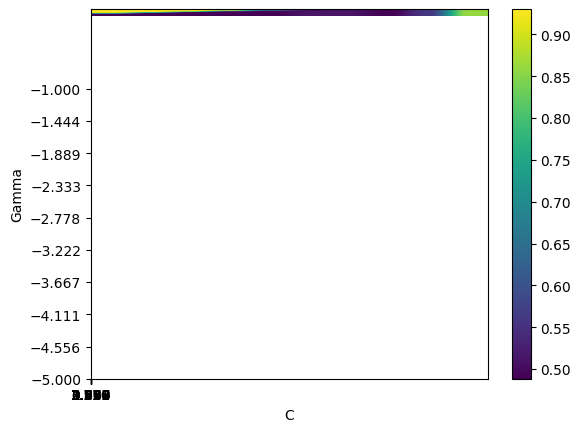

In [35]:
svm = SVC(kernel="precomputed")
vect_c = np.logspace(0, 4, 10)
vect_gamma = np.logspace(-5, -1, 10) #regarder les C avant
#et changer le gamma dans la hellinger distance
val_err_rate = np.empty((vect_c.shape[0], vect_gamma.shape[0]))
train_err_rate = np.empty((vect_c.shape[0], vect_gamma.shape[0]))
for ind_gamma, gamma in enumerate(vect_gamma) :
    K_train = hellinger_kernel(X_train, X_train, gamma)
    K_val = hellinger_kernel(X_val,X_train, gamma)
    for ind_c, c in enumerate(vect_c):
        svm.C = c
        svm.fit(K_train, Y_train)
        val_err_rate [ind_c][ind_gamma]= 1 - accuracy_score(Y_val, svm.predict(K_val))
        train_err_rate[ind_c][ind_gamma] = 1 - accuracy_score(Y_train, svm.predict(K_train))    

plt.imshow(val_err_rate, extent=[min(vect_c),max(vect_c),min(vect_gamma),max(
vect_gamma)],aspect="auto")
plt.colorbar()
plt.xlabel("C")
plt.ylabel("Gamma")
plt.xticks(np.linspace(0, 4, 10))
plt.yticks(np.linspace(-5, -1, 10))
        

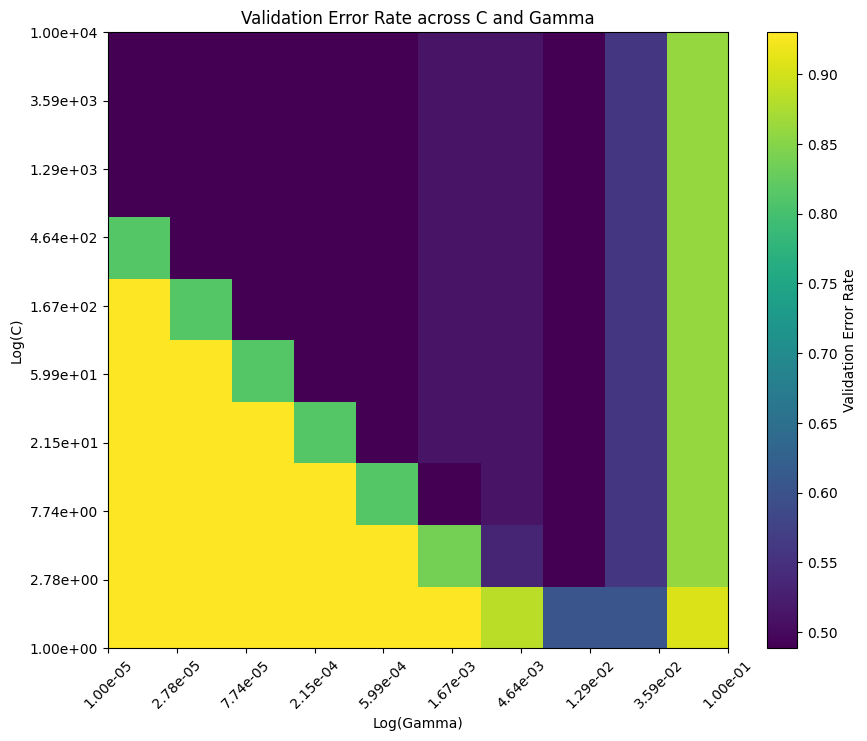

In [36]:
plt.figure(figsize=(10, 8))
plt.imshow(
    val_err_rate,
    extent=[np.log10(vect_gamma.min()), np.log10(vect_gamma.max()), np.log10(vect_c.min()), np.log10(vect_c.max())],
    aspect="auto",
    origin="lower",
    cmap="viridis"
)
plt.colorbar(label="Validation Error Rate")
plt.xlabel("Log(Gamma)")
plt.ylabel("Log(C)")
plt.xticks(np.log10(vect_gamma), labels=[f"{g:.2e}" for g in vect_gamma], rotation=45)
plt.yticks(np.log10(vect_c), labels=[f"{c:.2e}" for c in vect_c])
plt.title("Validation Error Rate across C and Gamma")
plt.show()

In [33]:
min_index = np.unravel_index(val_err_rate.argmin(), val_err_rate.shape)
ind_min_c, ind_min_gamma = min_index

c_opt = vect_c[ind_min_c]
gamma_opt = vect_gamma[ind_min_gamma]

print("\nOptimal C = {:.4f}".format(c_opt))
print("\nOptimal Gamma = {:.4f}".format(gamma_opt))


Optimal C = 4.6416

Optimal Gamma = 0.0100


In [37]:
clf_svm = SVC(kernel="precomputed", C = c_opt) 
K_train = hellinger_kernel(X_train, X_train, gamma_opt)
K_val = hellinger_kernel(X_val,X_train, gamma_opt)
K_test = hellinger_kernel(X_test,X_train, gamma_opt)
clf_svm.fit(K_train, Y_train)
err_test = 1 - accuracy_score(Y_test, clf_svm.predict(K_test))
print("Optimal Linear SVM : test error rate = {}".format(err_test))


Optimal Linear SVM : test error rate = 0.37209302325581395
